In [2]:
import sys
sys.path.append('..')

from gquant.dataframe_flow import run, load_workflow, viz_graph
import nxpd
from nxpd import draw

In [3]:
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38970 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 536.39 GB


We can open the status page in the brwoser by following javascript commands

In [4]:
from IPython.display import HTML
javascript = """
<script type="text/Javascript">
    function check_status(){
        var url = document.location.href;
        var index = url.indexOf(':8888');
        var status = url.substr(0, index)+":8787";
        window.open(status,'_blank');
    }
    check_status();
</script>
"""
HTML(javascript)

# Prepare distributed CSV files <span style="color:red">(not necessary if the dataset is already prepared)</span>

Following is the code to prepare the dataset as mulitple csv files that we can use dask_cuda to load them

In [3]:
import dask.dataframe as dd
import os
node_csv = {"id": "node_csvdata",
            "type": "CsvStockLoader",
            "conf": {"path": "/Project/data/stocks/stock_price_hist.csv.gz"},
            "inputs": []}

node_sort = {"id": "node_sort",
             "type": "SortNode",
             "conf": {"keys": ['asset', 'datetime']},
             "inputs": ["node_csvdata"]}

df = run([node_csv, node_sort],
         outputs=['node_sort'],
         replace={'node_csvdata': {"load": True}})[0]
os.makedirs('many-small', exist_ok=True)
print(df)
df = dd.from_pandas(df.to_pandas(), npartitions=8).to_csv('many-small/*.csv', index=False)

/conda/envs/rapids/lib/python3.6/site-packages/cudf-0.7.1-py3.6-linux-x86_64.egg/cudf/io/hdf.py:13: UserWarning: Using CPU via Pandas to read HDF dataset, this may be GPU accelerated in the future
  warnings.warn("Using CPU via Pandas to read HDF dataset, this may "


                  datetime  open  close  high   low  asset  volume
1870 1990-01-02T00:00:00.000  1.12   1.12  1.12  1.12     93     0.0
1871 1990-01-03T00:00:00.000   1.0    1.0   1.0   1.0     93    15.6
1872 1990-01-04T00:00:00.000   1.0    1.0   1.0   1.0     93     0.0
1873 1990-01-05T00:00:00.000   1.0    1.0   1.0   1.0     93     0.0
1874 1990-01-08T00:00:00.000   1.0    1.0   1.0   1.0     93     0.6
1875 1990-01-09T00:00:00.000   1.0    1.0   1.0   1.0     93     0.0
1876 1990-01-10T00:00:00.000   1.0    1.0   1.0   1.0     93     0.0
1877 1990-01-11T00:00:00.000  1.12   1.12  1.12  1.12     93     1.6
1878 1990-01-12T00:00:00.000  1.12   1.12  1.12  1.12     93     0.0
1879 1990-01-15T00:00:00.000   1.0    1.0   1.0   1.0     93     1.2
[19277152 more rows]


In [5]:
!cat ../task_example/dask_task.yaml

- id: node_csvdata_dask
  type: DaskCsvStockLoader
  conf:
    path: many-small
  inputs: []
- id: node_minVolume
  type: VolumeFilterNode
  conf:
    min: 50.0
  inputs: 
    - node_csvdata_dask
- id: node_sort
  type: SortNode
  conf:
    keys: 
      - asset
      - datetime
  inputs: 
    - node_minVolume
- id: node_volumeMean
  type: AverageNode
  conf:
    column: volume
  inputs: 
    - node_sort
- id: node_outputCsv
  type: OutCsvNode
  conf:
    path: symbol_volume.csv
  inputs:
    - node_volumeMean


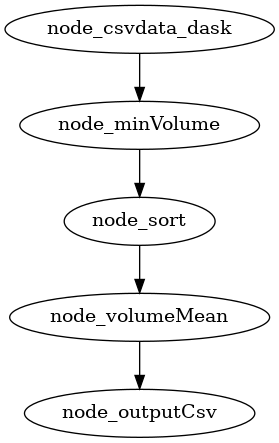

In [6]:
obj = load_workflow('../task_example/dask_task.yaml')
G = viz_graph(obj)
draw(G, show='ipynb')

In [7]:
df = run(obj, ['node_outputCsv'], {})[0]